In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import scipy.stats as stats
from itertools import combinations

In [29]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.family'] =  "sans-serif" 
rcParams['font.sans-serif'] = "Liberation Sans"  # font Arial
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [36]:
# Loading data
Datadir='/data2/Hap3D_Figures/h-trans-chr1/nbt-hg001-chr1'
##fsnp_list=f'{Datadir}/frag-snp.list'  ## 6bp snp filter
##fmap_list=f'{Datadir}/frag-map.list' ## mapping info by 
fhap_list=f'{Datadir}/dip3d-snp-tag-frag-hap-list' ## dip3d
giab_list=f'{Datadir}/pore-c-snp-tag-frag-hap-list' ## whatshap raw
#fhap_list=f'{Datadir}/dip3d-impute-frag-hap-list' ## dip3d
#giab_list=f'{Datadir}/pore-c-impute-frag-hap-list' ## whatshap raw
out_dir='/data2/Hap3D_Figures/h-trans-chr1/nbt-hg001-chr1'

# dip3d
fhap=pd.read_csv(fhap_list, header=None, sep='\t', skiprows=2, usecols = [0,1,2,3,7],
                 names=['rid','fid','cid','pos','hp'] )
# filter hp==0
fhap = fhap.loc[fhap.hp!=0, :].reset_index(drop=True)

# giab
giab_hap=pd.read_csv(giab_list, header=None, sep='\t', skiprows=2, usecols = [0,1,2,3,7],
                 names=['rid','fid','cid','pos','hp'] )
# filter hp==0
giab_hap = giab_hap.loc[giab_hap.hp!=0, :].reset_index(drop=True)
giab_hap

,rid,fid,cid,pos,hp
0,429,0,0,203285162,1
1,429,4,0,203815602,1
2,666,3,0,101349308,2
3,855,0,0,197548523,2
4,1004,0,0,189536159,1
...,...,...,...,...,...
9228501,125421013,3,0,54370900,2
9228502,125421017,2,0,164091777,2
9228503,125421055,1,0,73801156,2
9228504,125421073,0,0,192944020,1


In [38]:
# hap h-trans ratio vs distance 
from itertools import combinations

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

def add_flatten_lists(the_lists):
    result = []
    for _list in the_lists:
        result += _list
    return result

def stats_Hap(df):
    df=df.loc[df.hp!=0,]
    df=df.sort_values(['rid','pos']).reset_index(drop=True)
    statsdf=df.groupby('rid')['pos'].apply(list).reset_index()
    statsdf['hp']=df.groupby('rid')['hp'].apply(list).reset_index()['hp']
    statsdf['fnum']=statsdf['pos'].apply(lambda x: len(x))
    statsdf=statsdf.loc[statsdf.fnum>1,]

    statsdf['isize']=statsdf.pos.apply(lambda x: [abs(i[0]-i[1]) for i in list(combinations(x,2))])
    statsdf['ihp']=statsdf.hp.apply(lambda x: [i[0]+i[1] for i in list(combinations(x,2))])
    statsdf['ihp']=statsdf.ihp.apply(lambda x: ['h' if i==3 else 'c' for i in x])

    statsdf['fid']=df.groupby('rid')['fid'].apply(list).reset_index()['fid']
    statsdf['adj']=statsdf.fid.apply(lambda x: ['a' if abs(i[0]-i[1])==1 else 'u' for i in list(combinations(x,2)) ])
    
    isize=add_flatten_lists(statsdf.isize)
    ihp=add_flatten_lists(statsdf.ihp)
    adj=add_flatten_lists(statsdf.adj)

    sdf=pd.DataFrame({'isize':isize,'ihp':ihp,'adj':adj})
    return sdf

def cal_htrans(sdf,min_freq=10,binsize=10**5):
    sdf['bin_isize']=sdf.isize.apply(lambda x: round(x/binsize)*binsize)
    sdf=sdf.groupby(['bin_isize','ihp'])['adj'].count().reset_index()
    sdf.columns=['bin_isize','interaction','freq']
    sdf=sdf.sort_values(['bin_isize','interaction']).reset_index(drop=True)

    hdf=sdf.groupby('bin_isize')['interaction'].apply(list).reset_index()
    hdf['freq']=sdf.groupby('bin_isize')['freq'].apply(list).reset_index()['freq']
    hdf['total_freq']=hdf.freq.apply(lambda x: sum(x))
    hdf=hdf.loc[hdf.total_freq>=min_freq,]
    hdf['itype']=hdf.interaction.apply(lambda x: 'b' if len(x)==2 else x[0])
    hdf['hratio']=hdf.apply(lambda x: x.freq[1]/(x.total_freq)*100 if x.itype=='b' else 0 if x.itype=='c' else 100,axis=1)
    return hdf

def cal_lowess(sdf,plotx=10**6,lowess_frac=0.05):
    hdf=cal_htrans(sdf)
    hdf=pd.DataFrame({'bin_isize':hdf.bin_isize/plotx,'hratio':hdf.hratio})
    
    ahdf=cal_htrans(sdf.loc[sdf.adj=='a',]) #   adjacent
    ahdf=pd.DataFrame({'bin_isize':ahdf.bin_isize/plotx,'hratio':ahdf.hratio})
    uhdf=cal_htrans(sdf.loc[sdf.adj=='u',]) # unadjacent
    uhdf=pd.DataFrame({'bin_isize':uhdf.bin_isize/plotx,'hratio':uhdf.hratio})
    
    hdf['lowess_hratio'] = lowess(hdf['hratio'],hdf['bin_isize'],frac=lowess_frac)[:,1]
    ahdf['lowess_hratio'] = lowess(ahdf['hratio'],ahdf['bin_isize'],frac=lowess_frac)[:,1]
    uhdf['lowess_hratio'] = lowess(uhdf['hratio'],uhdf['bin_isize'],frac=lowess_frac)[:,1]
    
    return hdf,ahdf,uhdf

In [39]:
# dip3d
dip3d_df=stats_Hap(fhap)
dip3d_hdf,d_ahdf,d_uhdf=cal_lowess(dip3d_df,lowess_frac=0.1)

# giab
giab_df=stats_Hap(giab_hap)
giab_hdf,g_ahdf,g_uhdf=cal_lowess(giab_df,lowess_frac=0.1)

/tmp/ipykernel_23699/3638842211.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['bin_isize']=sdf.isize.apply(lambda x: round(x/binsize)*binsize)
/tmp/ipykernel_23699/3638842211.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['bin_isize']=sdf.isize.apply(lambda x: round(x/binsize)*binsize)
/tmp/ipykernel_23699/3638842211.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [40]:
giab_hdf

,bin_isize,hratio,lowess_hratio
0,0.0,9.628360,10.775205
1,0.1,10.174493,10.798312
2,0.2,10.348068,10.821385
3,0.3,10.349107,10.844424
4,0.4,10.285420,10.867428
...,...,...,...
2437,243.7,72.222222,73.608337
2440,244.0,70.000000,73.630519
2441,244.1,68.750000,73.637863
2442,244.2,76.923077,73.645181


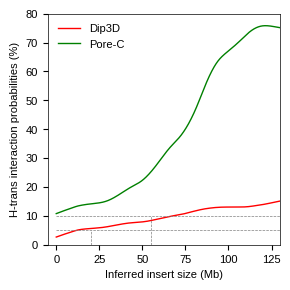

In [44]:
#  H-trans vs distance plot curve
plt.figure(figsize = (3,3)) 
plt.plot(dip3d_hdf['bin_isize'],dip3d_hdf['lowess_hratio'],color='r', label="Dip3D") 
plt.plot(giab_hdf['bin_isize'],giab_hdf['lowess_hratio'],color='g', label="Pore-C") 
plt.plot([0,130],[5,5],color='grey',linestyle='--',linewidth=0.5)
plt.plot([0,130],[10,10],color='grey',linestyle='--',linewidth=0.5)
plt.plot([20,20],[0,5],color='grey',linestyle='--',linewidth=0.5)
plt.plot([55,55],[0,10],color='grey',linestyle='--',linewidth=0.5)
plt.legend(frameon=False)
plt.xlim(-5,130)
plt.ylim(0,80)
plt.xlabel('Inferred insert size (Mb)')
plt.ylabel('H-trans interaction probabilities (%)')

fig=out_dir+'/haplotag_htrans_vs_distance.pdf'
plt.savefig(fig, bbox_inches = 'tight')
plt.show()